# 🧩 Cell 1: Install & Import Libraries
#

In [1]:
# ==============================================
# 🧩 Cell 1: Import Libraries (GPU Compatible)
# ==============================================

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import joblib
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ✅ Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0].name}")
else:
    print("⚠️ No GPU found — using CPU fallback.")

print(f"TensorFlow version: {tf.__version__}")


✅ GPU detected: /physical_device:GPU:0
TensorFlow version: 2.19.0


# 📁 Cell 2: Upload & Load Dataset


In [ ]:


print("📤 Upload your solar dataset (e.g. solarenergy.csv)")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"\n✅ File uploaded: {filename}")

try:
    df = pd.read_csv(filename)
except UnicodeDecodeError:
    df = pd.read_csv(filename, encoding='latin-1')

print("\n📊 Dataset Overview:")
print(df.head())
print(f"\nShape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")


📤 Upload your solar dataset (e.g. solarenergy.csv)


Saving solarenergy.csv to solarenergy.csv

✅ File uploaded: solarenergy.csv

📊 Dataset Overview:
           Datetime  solar_mw wind-direction  wind-speed  humidity  \
0   03/08/2020 0:00     11385             27         7.5      75.0   
1  02/08/2020 23:00     12390             27         7.5      77.0   
2  02/08/2020 22:00     13312             27         7.5      70.0   
3  02/08/2020 21:00     13832             27         7.5      33.0   
4  02/08/2020 20:00     14038             27         7.5      21.0   

   average-wind-speed-(period)  average-pressure-(period)  temperature  
0                          8.0                      29.82         69.0  
1                          5.0                      29.85         69.0  
2                          0.0                      29.89         69.0  
3                          0.0                      29.91         69.0  
4                          3.0                      29.89         69.0  

Shape: (116117, 8)
Columns: ['Datetime', 's

/tmp/ipython-input-4050735511.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [ ]:


import pandas as pd
import numpy as np

print("🧹 Cleaning & preparing solarenergy.csv ...")

# Ensure proper dtype inference and avoid warnings
df = pd.read_csv("solarenergy.csv", low_memory=False)

# ✅ Step 1: Convert 'Datetime' to pandas datetime object
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%d/%m/%Y %H:%M", errors="coerce")

# Drop invalid datetime rows
df = df.dropna(subset=["Datetime"]).sort_values("Datetime")

# ✅ Step 2: Convert all numeric columns (except Datetime)
for col in df.columns:
    if col != "Datetime":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# ✅ Step 3: Set Datetime as index
df = df.set_index("Datetime")

# ✅ Step 4: Resample hourly and interpolate missing values
df = df.resample("1h").mean(numeric_only=True).interpolate(method="time")

# ✅ Step 5: Rename key columns for consistency
df = df.rename(columns={"solar_mw": "Power", "temperature": "Temperature"})

print("\n✅ Data successfully cleaned and resampled!")
print(f"📊 Shape after cleaning: {df.shape}")
print(f"🕐 Time range: {df.index.min()} → {df.index.max()}")
print(f"⏱️ Total duration: {(df.index.max() - df.index.min()).days} days")

print("\n📋 Columns:")
print(df.columns.tolist())

print("\n🔍 Preview:")
print(df.head())


🧹 Cleaning & preparing solarenergy.csv ...

✅ Data successfully cleaned and resampled!
📊 Shape after cleaning: (116232, 7)
🕐 Time range: 2007-05-01 01:00:00 → 2020-08-03 00:00:00
⏱️ Total duration: 4842 days

📋 Columns:
['Power', 'wind-direction', 'wind-speed', 'humidity', 'average-wind-speed-(period)', 'average-pressure-(period)', 'Temperature']

🔍 Preview:
                      Power  wind-direction  wind-speed  humidity  \
Datetime                                                            
2007-05-01 01:00:00  7190.0             NaN         NaN       NaN   
2007-05-01 02:00:00  6803.0             NaN         NaN       NaN   
2007-05-01 03:00:00  6583.0             NaN         NaN       NaN   
2007-05-01 04:00:00  6452.0             NaN         NaN       NaN   
2007-05-01 05:00:00  6445.0             NaN         NaN       NaN   

                     average-wind-speed-(period)  average-pressure-(period)  \
Datetime                                                                    

🔧 Handling missing values...

Missing values before handling:
Power                               0
wind-direction                 105243
wind-speed                     113312
humidity                       113312
average-wind-speed-(period)    113312
average-pressure-(period)      113312
Temperature                    113312
dtype: int64

Missing values after handling:
Power                          0
wind-direction                 0
wind-speed                     0
humidity                       0
average-wind-speed-(period)    0
average-pressure-(period)      0
Temperature                    0
dtype: int64


/tmp/ipython-input-3430678012.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128262 (\N{HIGH BRIGHTNESS SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


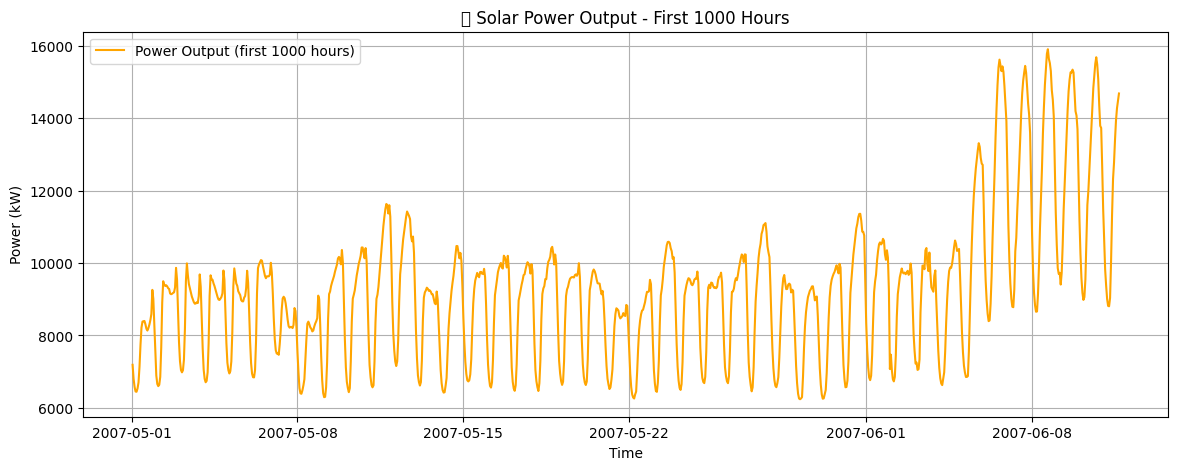

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


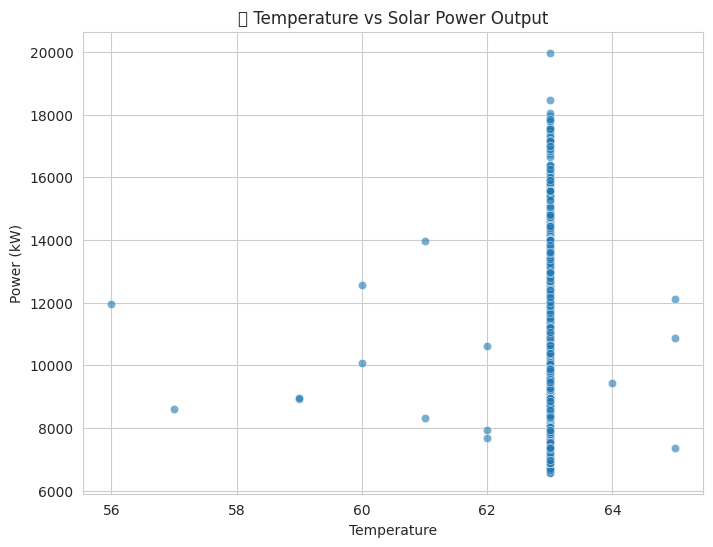

In [ ]:
# ==============================================
# 🧹 Cell 3.1: Handle Missing Values + Visualize
# ==============================================

import matplotlib.pyplot as plt
import seaborn as sns

print("🔧 Handling missing values...")

# Count missing values
missing_before = df.isnull().sum()
print("\nMissing values before handling:")
print(missing_before)

# 1️⃣ Interpolate numeric columns over time
df = df.interpolate(method='time', limit_direction='both')

# 2️⃣ Backward/forward fill as fallback
df = df.fillna(method='bfill').fillna(method='ffill')

# Count again
missing_after = df.isnull().sum()
print("\nMissing values after handling:")
print(missing_after)

# ✅ Quick visual sanity check
plt.figure(figsize=(14,5))
plt.plot(df.index[:1000], df['Power'][:1000], label='Power Output (first 1000 hours)', color='orange')
plt.title("🔆 Solar Power Output - First 1000 Hours")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.grid(True)
plt.show()

# Temperature vs Power correlation
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.scatterplot(x='Temperature', y='Power', data=df.sample(1000, random_state=42), alpha=0.6)
plt.title("🌡️ Temperature vs Solar Power Output")
plt.xlabel("Temperature")
plt.ylabel("Power (kW)")
plt.show()


In [ ]:
# ==============================================
# 🧩 Cell 3.2: Time Continuity Check
# ==============================================

import pandas as pd

print("⏱️ Checking time continuity...")

time_diff = df.index.to_series().diff().dropna()
unique_gaps = time_diff.value_counts()

print(f"\n🔹 Most common time gap: {unique_gaps.index[0]}")
print(f"🔹 Unique gaps found: {len(unique_gaps)}")

if len(unique_gaps) == 1 and unique_gaps.index[0] == pd.Timedelta(hours=1):
    print("✅ Perfect hourly continuity — ready for time-series modeling!")
else:
    print("⚠️ Warning: Irregular or missing timestamps detected.")
    print(unique_gaps.head())


⏱️ Checking time continuity...

🔹 Most common time gap: 0 days 01:00:00
🔹 Unique gaps found: 1
✅ Perfect hourly continuity — ready for time-series modeling!


Top correlations with Power:
Power                          1.000000
average-pressure-(period)      0.050573
humidity                      -0.012095
wind-direction                -0.023149
average-wind-speed-(period)   -0.032967
Temperature                   -0.044145
wind-speed                    -0.051593
Name: Power, dtype: float64


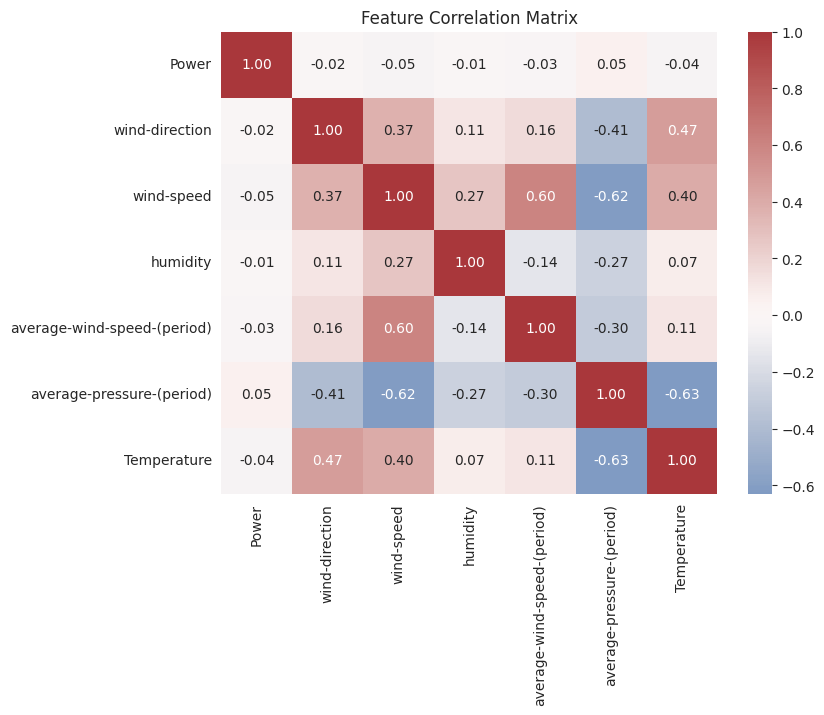

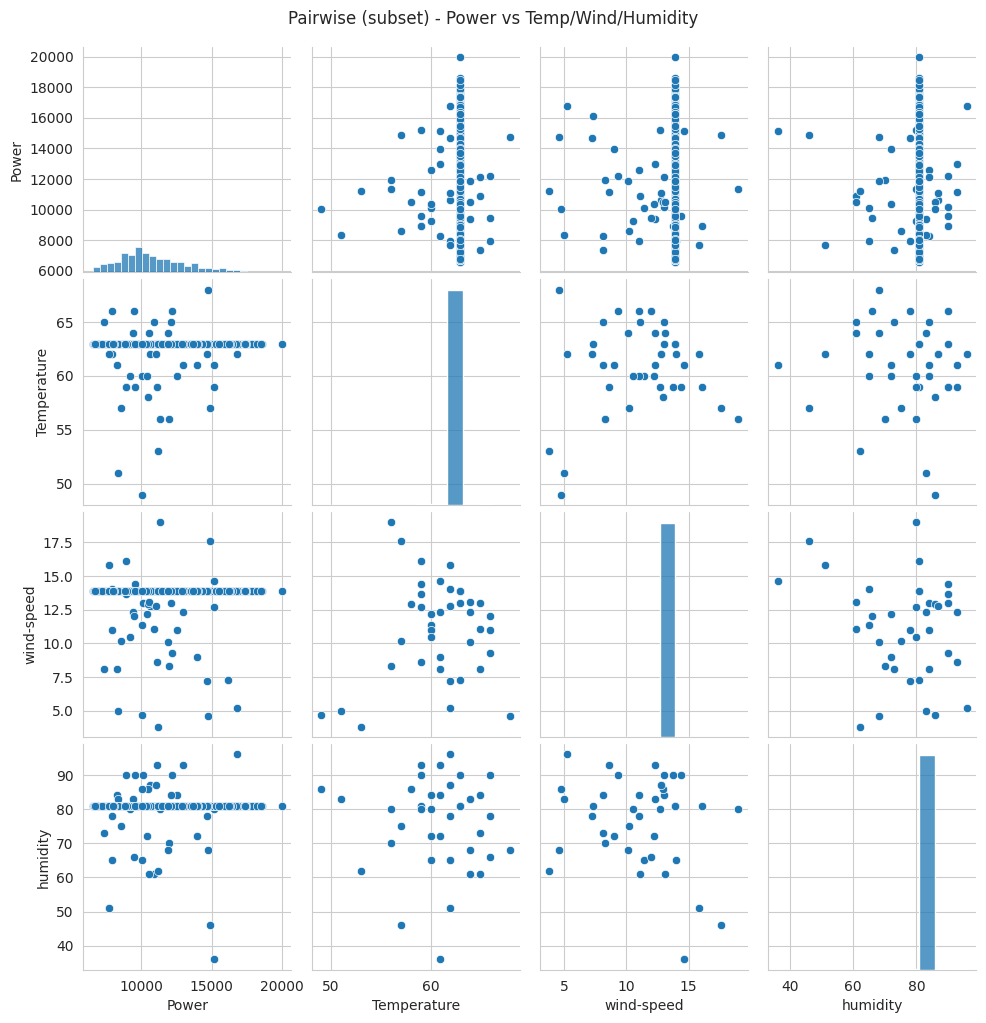

In [ ]:
# ==============================================
# 📊 Cell 3.3: Correlation Summary (Power vs features)
# ==============================================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Correlation with Power
corr = df.corr()
print("Top correlations with Power:")
print(corr["Power"].sort_values(ascending=False).head(10))

# Heatmap (sample to speed up plotting)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

# Pairplot (random subset for visibility)
sample = df.sample(min(2000, len(df)), random_state=42)
sns.pairplot(sample[["Power","Temperature","wind-speed","humidity"]])
plt.suptitle("Pairwise (subset) - Power vs Temp/Wind/Humidity", y=1.02)
plt.show()


In [ ]:
# ==============================================
# ⚙️ Cell 4: Feature Engineering
# ==============================================

import numpy as np
import pandas as pd

print("⚙️ Performing feature engineering...")

# Temporal features
df["Hour"] = df.index.hour
df["DayOfYear"] = df.index.dayofyear
df["Month"] = df.index.month
df["DayOfWeek"] = df.index.dayofweek
df["IsWeekend"] = (df.index.dayofweek >= 5).astype(int)
df["Quarter"] = df.index.quarter

# Cyclical encodings (helps LSTM learn seasonal cycles)
df["Hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
df["Hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

# Lag and rolling features (for temporal context)
df["Power_lag1"] = df["Power"].shift(1)
df["Power_lag24"] = df["Power"].shift(24)          # same hour previous day
df["Power_roll6"] = df["Power"].rolling(window=6, min_periods=1).mean()
df["Power_roll24"] = df["Power"].rolling(window=24, min_periods=1).mean()

# Convert any non-numeric columns (safely handle wind-direction)
df["wind-direction"] = pd.to_numeric(df["wind-direction"], errors="coerce")

# Fill new NaNs from lags/rolling
df = df.bfill().ffill()

print("\n✅ Feature engineering complete.")
print(f"Total columns after feature creation: {len(df.columns)}")
print("Columns:\n", df.columns.tolist())
print("\nSample preview:")
print(df.head(5))


⚙️ Performing feature engineering...

✅ Feature engineering complete.
Total columns after feature creation: 21
Columns:
 ['Power', 'wind-direction', 'wind-speed', 'humidity', 'average-wind-speed-(period)', 'average-pressure-(period)', 'Temperature', 'Hour', 'DayOfYear', 'Month', 'DayOfWeek', 'IsWeekend', 'Quarter', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Power_lag1', 'Power_lag24', 'Power_roll6', 'Power_roll24']

Sample preview:
                      Power  wind-direction  wind-speed  humidity  \
Datetime                                                            
2007-05-01 01:00:00  7190.0            28.0        13.9      81.0   
2007-05-01 02:00:00  6803.0            28.0        13.9      81.0   
2007-05-01 03:00:00  6583.0            28.0        13.9      81.0   
2007-05-01 04:00:00  6452.0            28.0        13.9      81.0   
2007-05-01 05:00:00  6445.0            28.0        13.9      81.0   

                     average-wind-speed-(period)  average-pressure-(peri

In [ ]:
# ==============================================
# 📊 Cell 5: Sequence Creation, Scaling & Split
# ==============================================

from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np

print("⚙️ Preparing data for LSTM training...")

# ✅ Select features (feel free to tweak)
feature_cols = [
    "Power_lag1", "Power_lag24", "Power_roll6", "Power_roll24",
    "Temperature", "wind-speed", "humidity",
    "Hour_sin", "Hour_cos", "Month_sin", "Month_cos", "IsWeekend"
]

# Ensure all columns exist in the DataFrame
feature_cols = [col for col in feature_cols if col in df.columns]
target_col = "Power"

print(f"🧩 Selected {len(feature_cols)} feature columns.")
print("Features:", feature_cols)
print(f"🎯 Target:", target_col)

# ✅ Extract features & target arrays
X_all = df[feature_cols].values
y_all = df[[target_col]].values

# ✅ Normalize both feature and target
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X_all)
y_scaled = y_scaler.fit_transform(y_all)

# Save scalers for later use (forecasting/deployment)
joblib.dump(X_scaler, "X_scaler.save")
joblib.dump(y_scaler, "y_scaler.save")

# ✅ Sequence creation function
def create_sequences(X, y, time_steps=72, horizon=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - horizon + 1):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps + horizon - 1])
    return np.array(Xs), np.array(ys)

# Time window hyperparameters
TIME_STEPS = 72   # Lookback = last 3 days (72 hours)
HORIZON = 3       # Predict 3 hours ahead

print(f"\n🕐 Sequence settings → Lookback: {TIME_STEPS} hours, Forecast Horizon: {HORIZON} hours")

# ✅ Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS, HORIZON)

print(f"\n📦 Created Sequences:")
print(f"   X shape = {X_seq.shape}  (samples, time_steps, features)")
print(f"   y shape = {y_seq.shape}")

# ✅ Split data into train, validation, test (time-based)
n = len(X_seq)
train_end = int(0.70 * n)
val_end = train_end + int(0.15 * n)

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test = X_seq[val_end:], y_seq[val_end:]

print(f"\n✅ Data Split Summary:")
print(f"   Training:   {X_train.shape[0]} samples ({X_train.shape[0]/n*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]} samples ({X_val.shape[0]/n*100:.1f}%)")
print(f"   Testing:    {X_test.shape[0]} samples ({X_test.shape[0]/n*100:.1f}%)")


⚙️ Preparing data for LSTM training...
🧩 Selected 12 feature columns.
Features: ['Power_lag1', 'Power_lag24', 'Power_roll6', 'Power_roll24', 'Temperature', 'wind-speed', 'humidity', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'IsWeekend']
🎯 Target: Power

🕐 Sequence settings → Lookback: 72 hours, Forecast Horizon: 3 hours

📦 Created Sequences:
   X shape = (116158, 72, 12)  (samples, time_steps, features)
   y shape = (116158, 1)

✅ Data Split Summary:
   Training:   81310 samples (70.0%)
   Validation: 17423 samples (15.0%)
   Testing:    17425 samples (15.0%)


In [ ]:
# ==============================================
# 🧠 Cell 6: Build & Train BiLSTM Model (GPU)
# ==============================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("🧠 Building BiLSTM model...")

# ✅ Model architecture
def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=input_shape)),
        Dropout(0.3),
        BatchNormalization(),

        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.25),
        BatchNormalization(),

        Bidirectional(LSTM(32)),
        Dense(64, activation="relu"),
        Dense(1)  # final output
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

# Build model
model = build_bilstm((X_train.shape[1], X_train.shape[2]))
model.summary()

# ✅ Callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_solar_lstm_gpu.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

# ✅ Training configuration
EPOCHS = 100
BATCH_SIZE = 64

print(f"\n🚀 Starting training for {EPOCHS} epochs (batch size = {BATCH_SIZE})...")

# ✅ Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete! Best model saved as 'best_solar_lstm_gpu.h5'")


🧠 Building BiLSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


🚀 Starting training for 100 epochs (batch size = 64)...
Epoch 1/100
1269/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0057 - mae: 0.0510
Epoch 1: val_loss improved from inf to 0.00138, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - loss: 0.0057 - mae: 0.0510 - val_loss: 0.0014 - val_mae: 0.0283 - learning_rate: 0.0010
Epoch 2/100
1270/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013 - mae: 0.0279
Epoch 2: val_loss improved from 0.00138 to 0.00091, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 9.1144e-04 - val_mae: 0.0228 - learning_rate: 0.0010
Epoch 3/100
1269/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.4575e-04 - mae: 0.0234
Epoch 3: val_loss improved from 0.00091 to 0.00074, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 9.4563e-04 - mae: 0.0234 - val_loss: 7.4429e-04 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 4/100
1270/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.9510e-04 - mae: 0.0214
Epoch 4: val_loss improved from 0.00074 to 0.00069, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 7.9506e-04 - mae: 0.0214 - val_loss: 6.9455e-04 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 5/100
1270/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.0376e-04 - mae: 0.0201
Epoch 5: val_loss improved from 0.00069 to 0.00062, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 7.0373e-04 - mae: 0.0201 - val_loss: 6.1597e-04 - val_mae: 0.0186 - learning_rate: 0.0010
Epoch 6/100
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.2678e-04 - mae: 0.0189
Epoch 6: val_loss improved from 0.00062 to 0.00054, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 6.2677e-04 - mae: 0.0189 - val_loss: 5.4149e-04 - val_mae: 0.0173 - learning_rate: 0.0010
Epoch 7/100
1269/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.7551e-04 - mae: 0.0181
Epoch 7: val_loss improved from 0.00054 to 0.00051, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 5.7550e-04 - mae: 0.0181 - val_loss: 5.1405e-04 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 8/100
1270/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.2893e-04 - mae: 0.0173
Epoch 8: val_loss did not improve from 0.00051
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - loss: 5.2892e-04 - mae: 0.0173 - val_loss: 5.2249e-04 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 9/100
1270/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9630e-04 - mae: 0.0168
Epoch 9: val_loss improved from 0.00051 to 0.00045, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 4.9628e-04 - mae: 0.0168 - val_loss: 4.4520e-04 - val_mae: 0.0156 - learning_rate: 0.0010
Epoch 10/100
1270/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.5686e-04 - mae: 0.0161
Epoch 10: val_loss did not improve from 0.00045
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - loss: 4.5685e-04 - mae: 0.0161 - val_loss: 4.5889e-04 - val_mae: 0.0160 - learning_rate: 0.0010
Epoch 11/100
1269/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.2774e-04 - mae: 0.0154
Epoch 11: val_loss improved from 0.00045 to 0.00044, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 4.2773e-04 - mae: 0.0154 - val_loss: 4.4385e-04 - val_mae: 0.0155 - learning_rate: 0.0010
Epoch 12/100
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.1504e-04 - mae: 0.0152
Epoch 12: val_loss improved from 0.00044 to 0.00044, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 4.1503e-04 - mae: 0.0152 - val_loss: 4.3596e-04 - val_mae: 0.0152 - learning_rate: 0.0010
Epoch 13/100
1270/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.9598e-04 - mae: 0.0148
Epoch 13: val_loss improved from 0.00044 to 0.00039, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 3.9597e-04 - mae: 0.0148 - val_loss: 3.9226e-04 - val_mae: 0.0143 - learning_rate: 0.0010
Epoch 14/100
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.7971e-04 - mae: 0.0145
Epoch 14: val_loss did not improve from 0.00039
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 3.7970e-04 - mae: 0.0145 - val_loss: 5.4760e-04 - val_mae: 0.0175 - learning_rate: 0.0010
Epoch 15/100
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.7126e-04 - mae: 0.0143
Epoch 15: val_loss improved from 0.00039 to 0.00039, saving model to best_solar_lstm_gpu.h5


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 3.7125e-04 - mae: 0.0143 - val_loss: 3.8672e-04 - val_mae: 0.0142 - learning_rate: 0.0010
Epoch 16/100
1270/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.5048e-04 - mae: 0.0139
Epoch 16: val_loss did not improve from 0.00039
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 3.5047e-04 - mae: 0.0139 - val_loss: 4.1149e-04 - val_mae: 0.0146 - learning_rate: 0.0010
Epoch 17/100
1269/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.4458e-04 - mae: 0.0138
Epoch 17: val_loss did not improve from 0.00039
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - loss: 3.4456e-04 - mae: 0.0138 - val_loss: 4.0677e-04 - val_mae: 0.0145 - learning_rate: 0.0010
Epoch 18/100
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.3452e-04 - mae: 0.0136
Epoch 18: val_loss did not improve from 0.00039
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 3.3451e-04 - mae: 0.0136 - val_loss: 5.2632e-04 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 19/100
1

1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 2.6828e-04 - mae: 0.0121 - val_loss: 3.7208e-04 - val_mae: 0.0136 - learning_rate: 5.0000e-04
Epoch 22/100
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.5326e-04 - mae: 0.0118
Epoch 22: val_loss did not improve from 0.00037
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 2.5326e-04 - mae: 0.0118 - val_loss: 3.8977e-04 - val_mae: 0.0139 - learning_rate: 5.0000e-04
Epoch 23/100
1269/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.4783e-04 - mae: 0.0117
Epoch 23: val_loss did not improve from 0.00037
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - loss: 2.4782e-04 - mae: 0.0117 - val_loss: 3.9024e-04 - val_mae: 0.0141 - learning_rate: 5.0000e-04
Epoch 24/100
1270/1271 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.4442e-04 - mae: 0.0116
Epoch 24: val_loss did not improve from 0.00037
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - loss: 2.4442e-04 - mae: 0.0116 - val_loss: 3.7624e-04 - val_mae: 0.0136 - learning_rate: 5.0000e-0

📊 Evaluating model performance...
2541/2541 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Train → RMSE: 282.25, MAE: 202.65, R²: 0.9860
Validation → RMSE: 393.46, MAE: 277.20, R²: 0.9751
Test → RMSE: 566.81, MAE: 392.85, R²: 0.9465


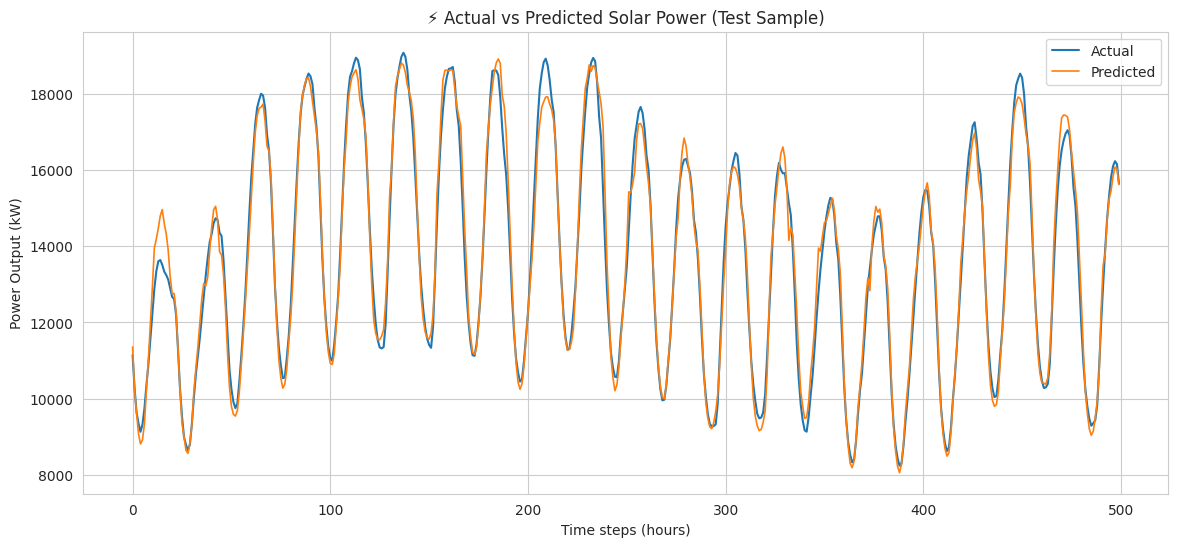

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


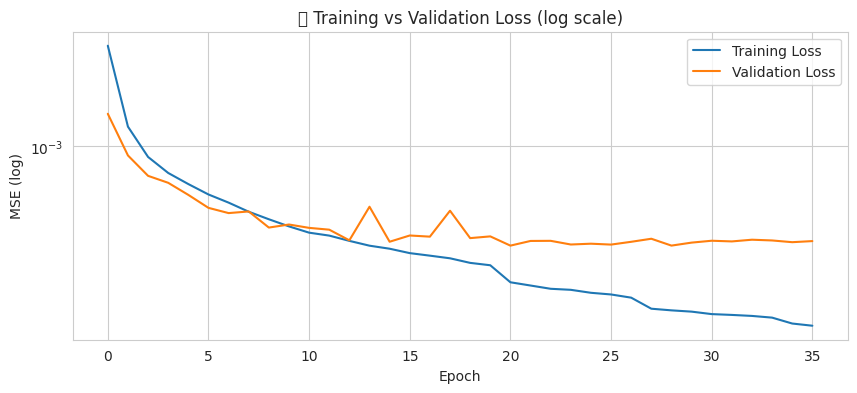

In [ ]:
# ==============================================
# 📈 Cell 7: Evaluate & Visualize Results
# ==============================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print("📊 Evaluating model performance...")

# Load best weights
model.load_weights("best_solar_lstm_gpu.h5")

# Predict on each split
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Inverse scaling
y_train_inv = y_scaler.inverse_transform(y_train)
y_val_inv = y_scaler.inverse_transform(y_val)
y_test_inv = y_scaler.inverse_transform(y_test)

y_train_pred_inv = y_scaler.inverse_transform(y_train_pred)
y_val_pred_inv = y_scaler.inverse_transform(y_val_pred)
y_test_pred_inv = y_scaler.inverse_transform(y_test_pred)

# ✅ Metrics function
def print_metrics(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{label} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

print_metrics(y_train_inv, y_train_pred_inv, "Train")
print_metrics(y_val_inv, y_val_pred_inv, "Validation")
print_metrics(y_test_inv, y_test_pred_inv, "Test")

# ✅ Plot actual vs predicted (Test sample)
plt.figure(figsize=(14,6))
plt.plot(y_test_inv[:500], label="Actual", lw=1.5)
plt.plot(y_test_pred_inv[:500], label="Predicted", lw=1.2)
plt.title("⚡ Actual vs Predicted Solar Power (Test Sample)")
plt.xlabel("Time steps (hours)")
plt.ylabel("Power Output (kW)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Plot training loss curves
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.yscale("log")
plt.title("📉 Training vs Validation Loss (log scale)")
plt.xlabel("Epoch")
plt.ylabel("MSE (log)")
plt.legend()
plt.grid(True)
plt.show()


🔮 Generating 24-hour solar power forecast...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


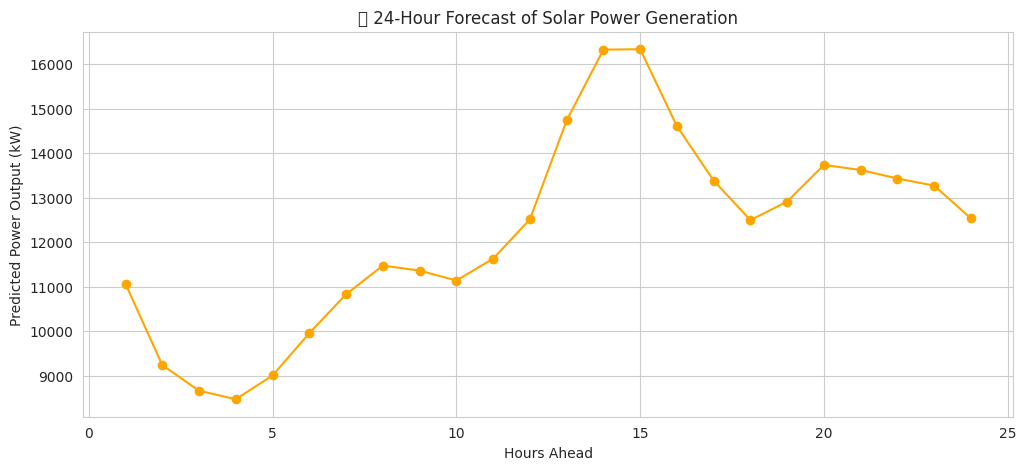

📈 Forecast Summary:
Average Power: 12193.75 kW
Peak Power:    16333.63 kW (Hour 15)
Lowest Power:  8467.21 kW (Hour 4)


In [ ]:
# ==============================================
# 🔮 Cell 8: Forecast Next 24 Hours (Future Prediction)
# ==============================================

import numpy as np
import matplotlib.pyplot as plt

print("🔮 Generating 24-hour solar power forecast...")

def forecast_future(model, last_seq, n_steps, y_scaler):
    seq = last_seq.copy()
    preds = []

    for _ in range(n_steps):
        pred_scaled = model.predict(seq.reshape(1, *seq.shape), verbose=0)[0, 0]
        preds.append(pred_scaled)

        # Shift window and insert latest prediction
        seq = np.roll(seq, -1, axis=0)
        seq[-1, 0] = pred_scaled  # assuming Power_lag1 is the first feature

    # Inverse scale predictions
    preds_inv = y_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    return preds_inv

# Use the last sequence from test data
last_seq = X_test[-1]

# Forecast next 24 hours
future_24h = forecast_future(model, last_seq, n_steps=24, y_scaler=y_scaler)

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(range(1, 25), future_24h, marker='o', linestyle='-', color='orange')
plt.title("🔮 24-Hour Forecast of Solar Power Generation")
plt.xlabel("Hours Ahead")
plt.ylabel("Predicted Power Output (kW)")
plt.grid(True)
plt.show()

# Summary stats
print("📈 Forecast Summary:")
print(f"Average Power: {future_24h.mean():.2f} kW")
print(f"Peak Power:    {future_24h.max():.2f} kW (Hour {future_24h.argmax()+1})")
print(f"Lowest Power:  {future_24h.min():.2f} kW (Hour {future_24h.argmin()+1})")


In [ ]:
# ==============================================
# 💾 Cell 9: Save and Download Model + Scalers
# ==============================================

import joblib
from google.colab import files

# ✅ Save final model in recommended Keras format
model.save("solar_lstm_forecast_model.keras")

# Also save MinMaxScalers for later normalization
joblib.dump(X_scaler, "X_scaler.save")
joblib.dump(y_scaler, "y_scaler.save")

# ✅ Compress all into one ZIP file for easy download
!zip -r solar_forecast_model_files.zip solar_lstm_forecast_model.keras X_scaler.save y_scaler.save

# Download ZIP file
files.download("solar_forecast_model_files.zip")

print("\n✅ Model, scalers, and configuration exported successfully!")
print("📦 File ready: solar_forecast_model_files.zip")


  adding: solar_lstm_forecast_model.keras (deflated 8%)
  adding: X_scaler.save (deflated 46%)
  adding: y_scaler.save (deflated 39%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Model, scalers, and configuration exported successfully!
📦 File ready: solar_forecast_model_files.zip
